In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas_datareader import data, wb
import seaborn as sns
%matplotlib inline

In [2]:
def get_data(symbol, start, end):
    b = data.DataReader(symbol, 'google', start=start, end=end)
    return b

def set_date_range(start_days_before_today,end_days_before_today):
    end=datetime.now().date()-timedelta(days=end_days_before_today)
    start=datetime.now().date()- timedelta(days=start_days_before_today)
    return start, end


#FUNCTIONS USED IN CLASSIFICATOIN
# Function to get daily returns
def getDailyReturns(df):
    dailyReturns = df.copy()
    #dailyReturns[:-1] = (df[1:] / df[:-1].values) - 1
    for i in range(1,len(df),1):
        dailyReturns[i]=(df[i]-df[i-1])/df[i-1]

    dailyReturns[0] = 0

    return dailyReturns * 100



#######################################

# A trading system can only be correctly evaluated based on expectancy... not on accuracy.
# so on the training data, we find what the expectancy was.. and based on that we choose the highehst expectancy system
# This is used to select best tuning parameter (the combination that maximizes expectancy)
def get_expectancy(Y_predicted,Close):#,Y_actual....this is what should be input... never mind..
    #test = stock.ix[(l - 99):(l - 1)]

    dr = getDailyReturns(Close)
    #test = test.join(dr, rsuffix='DR')

    #test['State'] = Y_predicted

    # Simulating:
    total_percentage=0
    effective_trades=0#so a day when u take double trades, counts for 2 trades worth of risk
    acc_size=100
    acc_graph=[]
    acc_graph.append(100)#this is like the equity curve...
    for i in range(0,len(Y_predicted),1):
        if Y_predicted[i]==0:
            continue
        elif abs(Y_predicted[i])==1:
            total_percentage = total_percentage + dr[i] * Y_predicted[i]
            acc_size+=acc_size* (dr[i]/100) * Y_predicted[i]
            acc_graph.append(acc_size)
            effective_trades+=1
        elif abs(Y_predicted[i]) == 2:
            total_percentage = total_percentage + dr[i] * Y_predicted[i]
            acc_size += acc_size * (dr[i]/100) * Y_predicted[i]
            acc_graph.append(acc_size)
            effective_trades+=2

    if effective_trades==0:
        expectancy=0
    else:
        expectancy=total_percentage/effective_trades

    return expectancy,(acc_size-100),acc_graph


########################


#this is to plot eq curve of spy
#l=len(stock)
#actualstock = stock.ix[1:(l), stock.columns == 'Close']

def eq_curves(X):
    dr = getDailyReturns(X['Close'])
    acc_size=100
    acc_graph=[]
    acc_graph.append(100)#this is like the equity curve...
    for i in range(0,len(X['Close']),1):
        acc_size+=acc_size* (dr[i]/100)
        acc_graph.append(acc_size)

    return acc_graph


######################################


In [3]:
import stockstats as ss
import pandas as pd

def indicators(stock_data):
    stock = ss.StockDataFrame.retype(stock_data)  # this just creates another pointer stock......but does not create another copy

    stock.get("close_delta")

    stock['adx']
    stock['rsi_6']
    stock['atr']
    stock.get('rsv_6')

    stock.get('kdjk')
    stock.get('kdjd')
    stock.get('kdjj')

    stock.get('macd')
    stock.get('middle')  # can use this to see if open is above the middle... then u can buy

    stock['change_in_atr'] = stock.apply(lambda row: row['close_delta'] / row['atr'],
                                         axis=1)  # change normalized by atr

    # subsetting only the final indicators and getting rid of the intermediate columns that were used for computaion of indicator
    # columns=['open', 'high', 'low', 'close','volume','change_in_atr','close_20_sma','close_10_sma','close_3_sma','boll_ub', 'boll_lb','adx_6_ema','rsi_6']
    # stock = stock[columns]
    return stock


#Function to get rolling mean of price
def getRollingMean(values, window):
    #df.rolling(centre=False,window=window).mean()
    rm=pd.rolling_mean(values, window= window)
    rm.rename("Rolling Mean",inplace=True)
    return rm

#Function to get rolling Standard Deviation of price
def getRollingSD(values, window):
    #df.rolling(centre=False,window=window).std()
    rsd=pd.rolling_std(values, window= window)
    rsd=rsd.rename("Rolling SD",inplace=True)
    return rsd

def getMomentumLastWeek(df):
    momentum = df.copy()
    momentum[5:] = (df[5:] / df[:-5].values) - 1
    momentum[0:4] = 0
    momentum.rename('Momentum',inplace=True)
    return momentum

def getDailyReturns(df):
    dailyReturns = df.copy()
    dailyReturns[1:] = (df[1:] / df[:-1].values) - 1
    dailyReturns[0] = 0
    dailyReturns.rename('Daily Returns',inplace=True)
    return dailyReturns

def getNextDailyReturns(df):
    nextdr=df.copy()
    nextdr[:-1]=(df[1:]/df[:-1].values)-1
    nextdr[-1]=-1
    nextdr.rename('Next Day Returns',inplace=True)
    return nextdr

def Bollingerband(rm,rstd):
    upper_band=rm+2*rstd
    lower_band=rm-2*rstd
    upper_band.rename('Upper Band',inplace=True)
    lower_band.rename('Lower Band',inplace=True)
    return upper_band,lower_band

In [4]:
start,end=set_date_range(1080,0)
spy_first = get_data("SPY", start, end)

#Now that we have the data, we create predictors (in this case various indicators using the functiond defined in Indicators.py
rolling_mean=getRollingMean(spy_first['Close'],63)
rolling_std=getRollingSD(spy_first['Close'],63)
momentum=getMomentumLastWeek(spy_first['Close'])
upper_band,lower_band=Bollingerband(rolling_mean,rolling_std)
DailyReturns=getDailyReturns(spy_first['Close'])
rm_DR=getRollingMean(DailyReturns,63)
rm_DR=rm_DR.rename('RM DR')
rstd_DR=getRollingSD(DailyReturns,63)
rstd_DR=rstd_DR.rename('RSD DR')
sharpeRatio = rm_DR / rstd_DR
sharpeRatio=sharpeRatio.rename("Sharpie Ratio")
priceRMRatio = (spy_first['Close'] / rolling_mean)
priceRMRatio=priceRMRatio.rename('Price RM Ratio')
#Now we just concatenate all the indicators found above to the initial data and create a new pandas data frame
spy_main=pd.concat([spy_first,rolling_mean,rolling_std,momentum,upper_band,lower_band,DailyReturns,rm_DR,rstd_DR,sharpeRatio,priceRMRatio],axis=1)

#getting more indicators from the stockstats package (library) which is used in Indicators.py
spy_extra=indicators(spy_first)

#so temp now has spy_main columns to which we add few more columns
temp=spy_main.reset_index()
temp['Day of Week'] = temp['Date'].apply(lambda time: time.dayofweek)
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
temp['Day of Week']=temp['Day of Week'].map(dmap)
temp=temp.set_index(temp['Date'])
temp.drop(['Date'],axis=1,inplace=True)
spy_mv=temp
#spy_mv.head()

#Upon concatenating spy_mv and spy_extra and dropping few repeated columns we now have out final dataset
spy_final=pd.concat([spy_mv,spy_extra],axis=1)
spy_final.drop(['open','high', 'low', 'close', 'volume'],axis=1,inplace=True)
spy_final.columns


# slight modification to spy_final (used in visualizations and classification)
spy_complete=spy_final.dropna()
spy_complete.head()

C:\Users\mcpea_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=63,center=False).mean()
C:\Users\mcpea_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=63,center=False).std()
C:\Users\mcpea_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,Volume,Rolling Mean,Rolling SD,Momentum,Upper Band,Lower Band,...,kdjd,kdjj_9,kdjj,close_12_ema,close_26_ema,macd,macds,macdh,middle,change_in_atr
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,187.62,188.36,187.00,188.25,89193125,183.627460,3.421184,0.010413,190.469827,176.785093,...,41.472968,79.032157,79.032157,186.373660,185.826348,0.547311,0.638506,-0.182388,187.870000,0.656628
2014-04-02,188.50,189.13,188.14,188.88,78773818,183.693968,3.482353,0.021139,190.658673,176.729263,...,50.227010,102.751261,102.751261,186.759259,186.054199,0.705061,0.651817,0.106488,188.716667,0.345460
2014-04-03,189.17,189.22,188.05,188.63,77435320,183.784603,3.535781,0.021942,190.856164,176.713042,...,58.415780,107.548401,107.548401,187.047071,186.246290,0.800781,0.681610,0.238343,188.633333,-0.140722
2014-04-04,189.64,189.70,186.10,186.40,169380705,183.840476,3.549042,0.004906,190.938561,176.742392,...,60.353863,71.982363,71.982363,186.947520,186.257747,0.689773,0.683242,0.013061,187.400000,-1.168847
2014-04-07,185.90,186.26,183.96,184.34,140802699,183.871905,3.544485,-0.014277,190.960874,176.782936,...,55.352161,25.341945,25.341945,186.546358,186.114868,0.431489,0.632892,-0.402805,184.853333,-1.058494


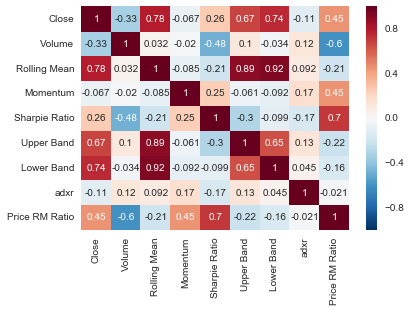

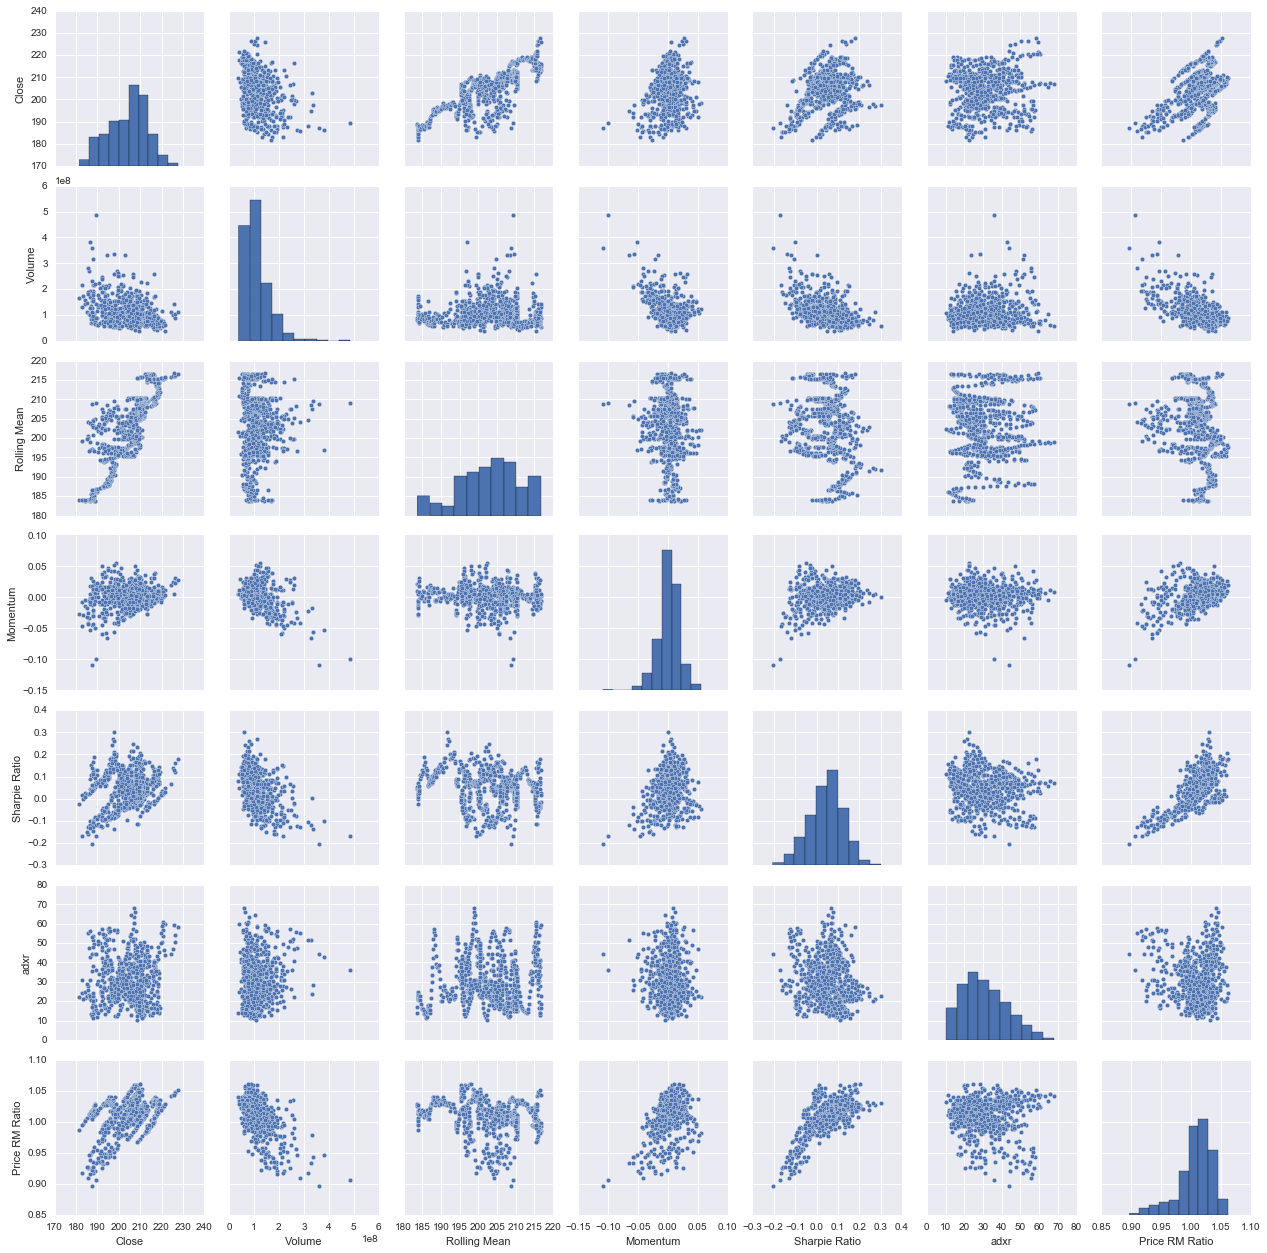

In [6]:
plt.figsize=(40,40)
sns.heatmap(spy_final[['Close','Volume','Rolling Mean','Momentum','Sharpie Ratio','Upper Band','Lower Band','Price RM Ratio','adxr']].ix[:360,].isnull(),yticklabels=False,cbar=False,cmap='viridis')
#plt.savefig('Null.jpg')


sns.heatmap(spy_final[['Close','Volume','Rolling Mean','Momentum','Sharpie Ratio','Upper Band','Lower Band','adxr','Price RM Ratio']].corr(),annot=True)
#plt.savefig('Correlation.jpg')



sns.pairplot(spy_complete[['Close','Volume','Rolling Mean','Momentum','Sharpie Ratio','adxr','Price RM Ratio']])
#plt.savefig('Scatter.jpg')

C:\Users\mcpea_000\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


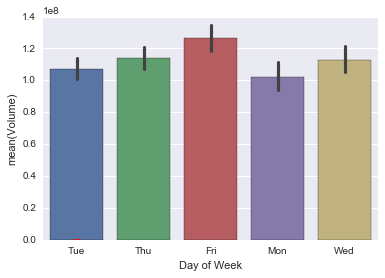

In [7]:
sns.barplot(x='Day of Week',y='Volume',data=spy_final)
#plt.savefig('ByDay.jpg')

In [8]:
NextDR=getNextDailyReturns(spy_complete['Close'])
spy_complete=pd.concat([spy_complete,NextDR],axis=1)
spy_complete.drop(['Daily Returns'],axis=1,inplace=True)


#We will make a copy of the dataframe usd for regression approach above, and use this for out classification methods.
stock=spy_complete.copy(deep=True)

#stock[['Close','close_delta','change_in_atr','Next Day Returns']]

#########################

#now we define the response and some SETUPS as categorical predictors

# defining the RESPONSE as multiple classes in terms of atr
#creating a response that has a long bias... and also puts more weight on large moe days.
def f(row):
    if row['Next Day Returns'] >= -0.003 and row['Next Day Returns'] <= 0.001:
        val=0
    if row['Next Day Returns'] >= -0.007 and row['Next Day Returns'] < -0.003:
        val=-1
    if row['Next Day Returns'] > 0.001 and row['Next Day Returns'] <= 0.005:
        val=1
    elif row['Next Day Returns'] > 0.005:
        val = 2
    elif row['Next Day Returns'] < -0.007:
        val=-2
    return val
stock['move_level'] = stock.apply(f, axis=1)#this is the response


#now for the PREDICTORS
# 20 period ma PREDICTOR
def f(row):
    if row['Close'] < row['Rolling Mean']:
        val = 0
    elif row['Close'] >= row['Rolling Mean']:
        val = 1
    return val
stock['above_Rolling Mean'] = stock.apply(f, axis=1)

# RSI predictor
def f(row):
    if row['rsi_6'] < 25:
        val = -1
    elif row['rsi_6'] >75:
        val = 1
    else:
        val=0
    return val
stock['rsi_over_bought_sold'] = stock.apply(f, axis=1)



# CANDLE PREDICTORS (DECISVE MOVE versus INDECISION)
def f(row):
    if abs(row['Close']-row['Open']) < 0.1* (row['High']-row['Low']):
        val = -1#doji
    elif abs(row['Close']-row['Open']) > 0.7* (row['High']-row['Low']):
        val = 1#big move
    else:
        val=0#nothing special
    return val
stock['candle_type'] = stock.apply(f, axis=1)



In [10]:
del stock['Next Day Returns']
del stock['Day of Week']

In [12]:

l=len(stock)
X_train = stock.ix[1:(l-100), stock.columns != 'move_level']
Y_train = stock.ix[1:(l-100), stock.columns == 'move_level']
X_test = stock.ix[(l-99):(l-1), stock.columns != 'move_level']
Y_test = stock.ix[(l-99):(l-1), stock.columns == 'move_level']



In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X_train)
#print(pca.explained_variance_ratio_)
x1=pca.fit_transform(X_train)
x2=pca.fit_transform(X_test)


l1=len(X_train)
l2=round(0.75*len(X_train))


X_1=X_train[1:l2]
X_2=X_train[(l2+1):l1]
Y_1=Y_train[1:l2]
Y_2=Y_train[(l2+1):l1]
#x11=x1[1:381]
#x12=x1[382:581]


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier



In [15]:
index_eq_curve=eq_curves(X_test)

index_returns = index_eq_curve[98]-index_eq_curve[0]


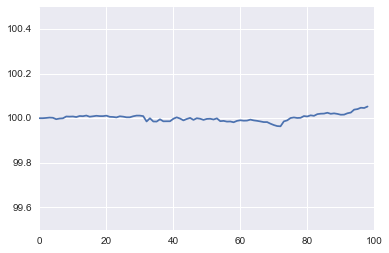

In [107]:
plt.plot(index_eq_curve)
plt.axis([0,100,99.5,100.5])
plt.savefig('Index_curve.jpg')

In [109]:
lda = LinearDiscriminantAnalysis()
lda.fit(x1,Y_train['move_level'].values)

predicted=lda.predict(x2)
exp,net_gain,eq_curve = get_expectancy(predicted, X_test['Close'])
accuracy=accuracy_score(Y_test, predicted)
print("LDA :")
print("Accuracy = ",accuracy, "; Expectancy = ",exp, "; % made = ",(net_gain))
print("Index returns = ",index_returns)

LDA :
Accuracy =  0.316326530612 ; Expectancy =  0.00247957984121 ; % made =  0.255666141151
Index returns =  0.0523886906273


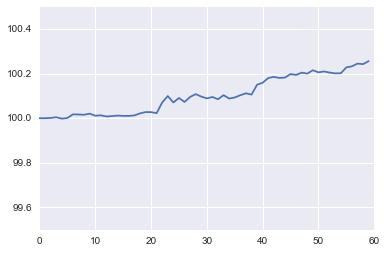

In [110]:
plt.plot(eq_curve)
plt.axis([0,60,99.5,100.5])
plt.savefig('LDA_equity.jpg')

QDA :
Accuracy =  0.326530612245 ; Expectancy =  0.00290499478511 ; % made =  0.215153491018
Index returns =  0.0523886906273


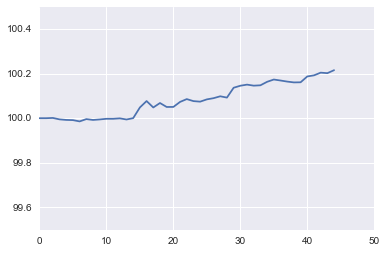

In [111]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x1,Y_train['move_level'].values)

predicted=qda.predict(x2)
exp,net_gain,eq_curve = get_expectancy(predicted, X_test['Close'])
accuracy=accuracy_score(Y_test, predicted)
print("QDA :" )
print("Accuracy = ",accuracy, "; Expectancy = ",exp, "; % made = ",(net_gain))
print("Index returns = ",index_returns)
plt.plot(eq_curve)
plt.axis([0,50,99.5,100.5])
plt.savefig('QDA_equity.jpg')

In [112]:
clf = SVC(C=0.1)
clf.fit(X_train,Y_train['move_level'].values)

predicted=clf.predict(X_test)
exp,net_gain,eq_curve = get_expectancy(predicted, X_test['Close'])
accuracy=accuracy_score(Y_test, predicted)
print("SVC C=0.01: ")
print("Accuracy = ",accuracy, "; Expectancy = ",exp, "; % made = ",(net_gain))


SVC C=0.01: 
Accuracy =  0.357142857143 ; Expectancy =  0 ; % made =  0


SVC kernel=poly, decision function = ovo: 
Accuracy =  0.183673469388 ; Expectancy =  0.000534620490929 ; % made =  0.104769118678
Index returns =  0.0523886906273


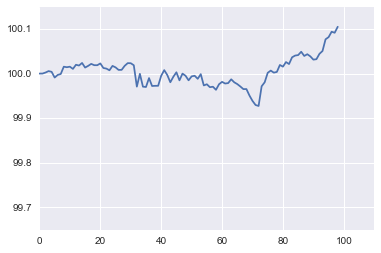

In [119]:
### Support Vector Classification. kernel=ploy
clf = SVC(kernel='poly',decision_function_shape='ovo',C=1)
clf.fit(X_train,Y_train['move_level'].values)

predicted=clf.predict(X_test)
exp,net_gain,eq_curve = get_expectancy(predicted, X_test['Close'])
accuracy=accuracy_score(Y_test, predicted)
print("SVC kernel=poly, decision function = ovo: ")

print("Accuracy = ",accuracy, "; Expectancy = ",exp, "; % made = ",(net_gain))
print("Index returns = ",index_returns)
plt.plot(eq_curve)
plt.axis([0,110,99.65,100.15])
plt.savefig('SVM_Ploy_equity.jpg')

In [114]:
### Support Vector Classification. kernel=‘sigmoid’
clf = SVC(kernel='sigmoid',C=1,decision_function_shape='ovo')
clf.fit(X_train,Y_train['move_level'].values)

predicted=clf.predict(X_test)
exp,net_gain,eq_curve = get_expectancy(predicted, X_test['Close'])
accuracy=accuracy_score(Y_test, predicted)
print("SVC kernel=sigmoid, decision function = ovo: ")

print("Accuracy = ",accuracy, "; Expectancy = ",exp, "; % made = ",(net_gain))
print("Index returns = ",index_returns)


SVC kernel=sigmoid, decision function = ovo: 
Accuracy =  0.357142857143 ; Expectancy =  0 ; % made =  0
Index returns =  0.0523886906273


In [115]:
### KNeighborsClassifier
### tuning K - here we use X_1, Y_1 to train and X_2 to select best model
highest_exp=0
best_k=1
exp=0
for k in range(1,59,1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_1, Y_1['move_level'].values)
    predicted = knn.predict(X_2)
    exp, net_gain, eq_curve = get_expectancy(predicted, X_2['Close'])
    if(exp>highest_exp):
        highest_exp=exp
        best_k=k
        print("k=",k," : exp =",exp)
print(best_k)

k= 1  : exp = 0.00043330571262
k= 2  : exp = 0.000453683275333
k= 24  : exp = 0.000570318948847
k= 25  : exp = 0.000669387840275
25


KNN with best k=  25 : 
Accuracy =  0.387755102041 ; Expectancy =  -0.000970868652151 ; % made =  -0.065078214226
Index returns =  0.0523886906273


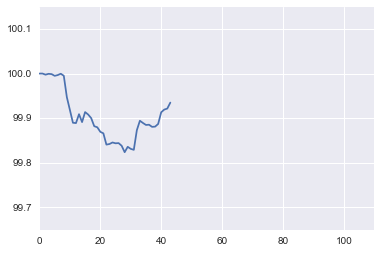

In [118]:
knn1 = KNeighborsClassifier(n_neighbors=best_k)
knn1.fit(X_train, Y_train['move_level'].values)

predicted=knn1.predict(X_test)
exp,net_gain,eq_curve = get_expectancy(predicted, X_test['Close'])
accuracy=accuracy_score(Y_test, predicted)
print("KNN with best k= ",best_k, ": ")

print("Accuracy = ",accuracy, "; Expectancy = ",exp, "; % made = ",(net_gain))
print("Index returns = ",index_returns)
plt.plot(eq_curve)
plt.axis([0,110,99.65,100.15])
plt.savefig('KNN_equity.jpg')

In [122]:
###RandomForestClassifier
highest_exp=0
best_n=0
best_i=0
avg_exp=0
from sklearn.ensemble import RandomForestClassifier
### tuning n_estimators and max_features
for n in range(2,100): 
    for i in range(2,8):
        rfc = RandomForestClassifier(n_estimators=n,max_features=i)
        rfc.fit(X_1, Y_1['move_level'].values)
        #print(rfc.predict(X_test))
        predicted = rfc.predict(X_2)
        exp, net_gain, eq_curve = get_expectancy(predicted, X_2['Close'])
        avg_exp+=exp
        avg_exp=avg_exp/7
        if(avg_exp>highest_exp):
            highest_exp=avg_exp
            best_n=n
            best_i=i

print(best_n)
print(highest_exp)
print(best_i)


2
0.000415339241276
6


n_trees= 2  : exp = 0.000158300325648
Accuracy =  0.214285714286 ; Expectancy =  0.000158300325648 ; % made =  0.0158132191898
Index returns =  0.0523886906273


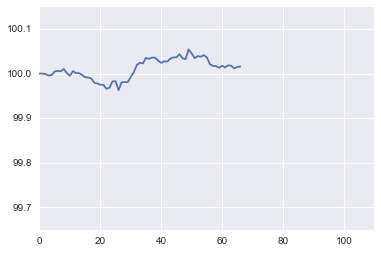

In [123]:
#Choosing the best random forest and using that to predict

rfc = RandomForestClassifier(n_estimators=best_n,max_features=best_i,random_state=1234)
rfc.fit(X_train, Y_train['move_level'].values)

predicted=rfc.predict(X_test)
exp,net_gain,eq_curve = get_expectancy(predicted, X_test['Close'])
accuracy=accuracy_score(Y_test, predicted)
print("n_trees=",best_n," : exp =",exp)
print("Accuracy = ",accuracy, "; Expectancy = ",exp, "; % made = ",(net_gain))
print("Index returns = ",index_returns)
plt.plot(eq_curve)
plt.axis([0,110,99.65,100.15])
plt.savefig('Random_best_equity.jpg')